![](https://media.discordapp.net/attachments/1047111061314220033/1176542563633737728/image.png)


Approche contre factuelle : quoi faire pour que l'exemple ne soit plus un outliers

base de référence : dataset classic


# Génération d'une base artificielle

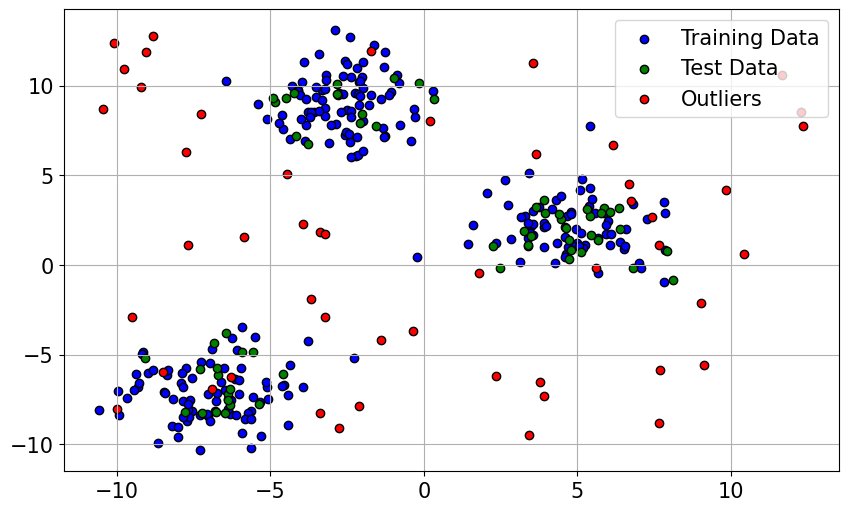

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


def generate_blobs(
    n_samples=300,
    n_features=2,
    n_clusters=3,
    cluster_std=1.0,
    n_outliers=50,
    random_seed=42,
):
    X, _ = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=n_clusters,
        cluster_std=cluster_std,
        random_state=random_seed,
    )

    # Générer des outliers
    rng = np.random.RandomState(random_seed)
    X_outliers = rng.uniform(low=X.min(), high=X.max(), size=(n_outliers, n_features))

    # Séparer les données en ensembles d'entraînement et de test
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test, X_outliers


def plot_blobs(X_train, X_test, X_outliers):
    plt.figure(figsize=(10, 6))
    # Plot les données d'entraînement
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c="blue", label="Training Data", edgecolors="k"
    )
    # Plot les données de test
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c="green", label="Test Data", edgecolors="k"
    )
    # Plot les outliers
    plt.scatter(
        X_outliers[:, 0], X_outliers[:, 1], c="red", label="Outliers", edgecolors="k"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


X_train, X_test, X_outliers = generate_blobs(
    n_samples=300, n_clusters=3, cluster_std=1.5, n_outliers=50
)
plot_blobs(X_train, X_test, X_outliers)

# Détection des outliers


In [17]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


def train_lof(X_train):
    """Train a Local Outlier Factor."""
    clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
    clf.fit(X_train)
    return clf


def train_one_class_svm(X_train, nu=0.05, gamma=2.0):
    """Train a One-Class SVM."""
    clf = OneClassSVM(gamma=gamma, kernel="rbf", nu=nu)
    clf.fit(X_train)
    return clf


def train_isolation_forest(X_train, random_state=0):
    """Train a Isolation Forest."""
    clf = IsolationForest(max_samples=100, random_state=random_state)
    clf.fit(X_train)
    return clf

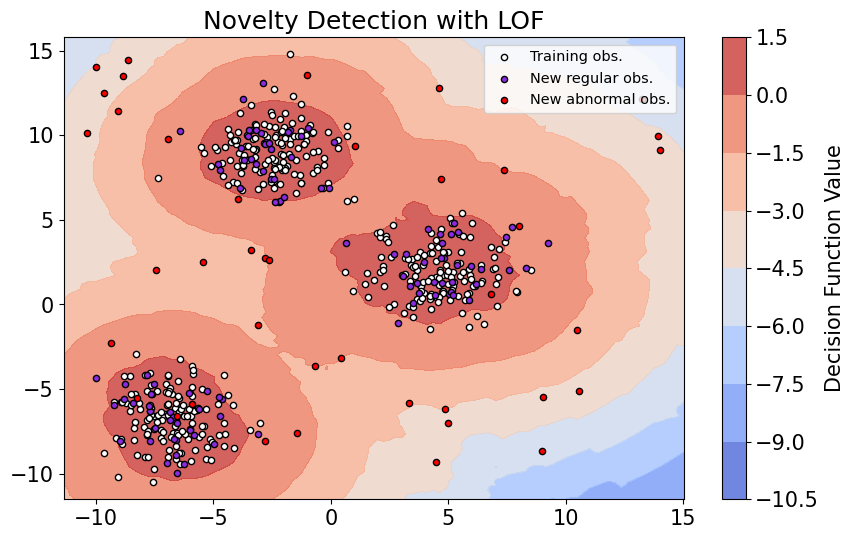

LocalOutlierFactor
error train: 34/400
errors novel regular: 14/100
errors novel abnormal: 4/40


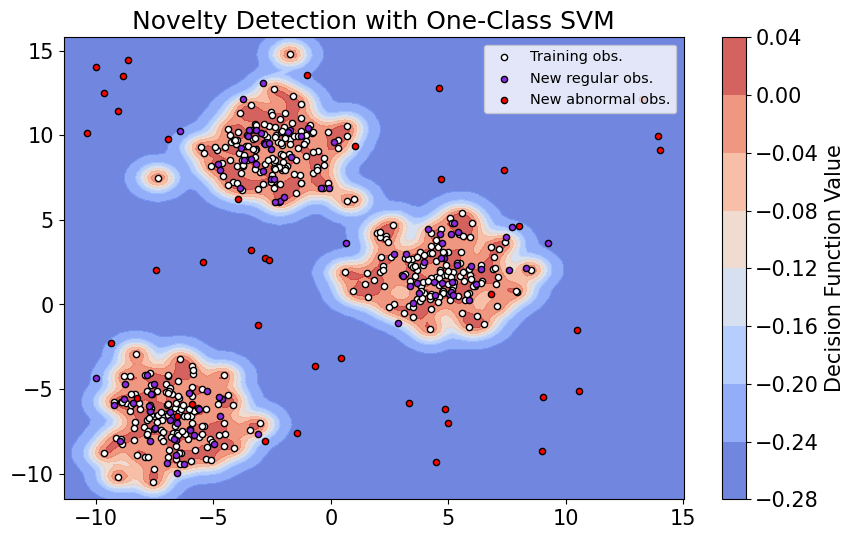

OneClassSVM
error train: 131/400
errors novel regular: 49/100
errors novel abnormal: 1/40


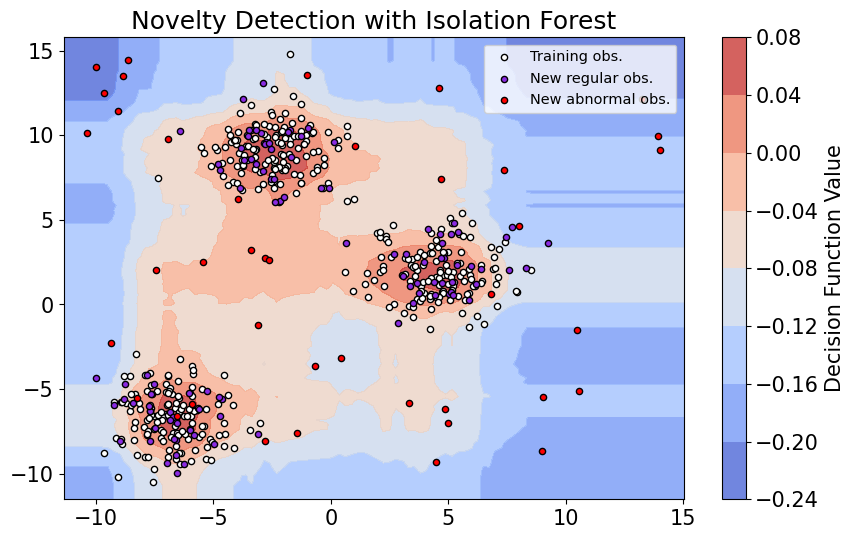

IsolationForest
error train: 144/400
errors novel regular: 42/100
errors novel abnormal: 2/40


In [50]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_boundary(clf, X, X_test, X_outliers, title):
    """Affiche les frontières de décision d'un classifieur."""
    plt.figure(figsize=(10, 6))

    # Create grid to plot decision boundaries
    x_min, x_max = (
        min(X[:, 0].min(), X_outliers[:, 0].min()) - 1,
        max(X[:, 0].max(), X_outliers[:, 0].max()) + 1,
    )
    y_min, y_max = (
        min(X[:, 1].min(), X_outliers[:, 1].min()) - 1,
        max(X[:, 1].max(), X_outliers[:, 1].max()) + 1,
    )
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Plot decision boundary
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    contour = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Add a colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label("Decision Function Value")

    # Plot training points
    plt.scatter(X[:, 0], X[:, 1], c="white", edgecolor="k", s=20, label="Training obs.")

    # Plot test points
    plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', edgecolor='k', s=20, label="New regular obs.")

    # Plot outliers
    plt.scatter(
        X_outliers[:, 0],
        X_outliers[:, 1],
        c="red",
        edgecolor="k",
        s=20,
        label="New abnormal obs.",
    )

    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize="x-small")
    plt.show()

    # Statistics
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
    print(clf.__class__.__name__)
    print(f"error train: {n_error_train}/{X_train.shape[0]}")
    print(f"errors novel regular: {n_error_test}/{X_test.shape[0]}")
    print(f"errors novel abnormal: {n_error_outliers}/{X_outliers.shape[0]}")


# Generate data
X_train, X_test, X_outliers = generate_blobs(
    n_samples=500, n_clusters=3, cluster_std=1.5, n_outliers=40
)

# Entraîner chaque modèle
lof_clf = train_lof(X_train)
svm_clf = train_one_class_svm(X_train)
iso_forest_clf = train_isolation_forest(X_train)

# Visualize decision boundaries for each model
plot_decision_boundary(lof_clf, X_train, X_test, X_outliers, "Novelty Detection with LOF")
plot_decision_boundary(
    svm_clf, X_train, X_test, X_outliers, "Novelty Detection with One-Class SVM"
)
plot_decision_boundary(
    iso_forest_clf, X_train, X_test, X_outliers, "Novelty Detection with Isolation Forest"
)

mais pourquoi me prédit il comme donnée exceptionnelle

- explications naives : on a un prédicteur : lof, svm ou arbre clf qui étant donné X exception ou pas... => on prend les méthodes qu'on a déjà vu pour expliquer les classifieurs. souligne les modifications mineures pour qu'il ne soit plus prédit comme étant une prédiction. est-ce que ça nous permet nous meme de voir . si donné prédite avec lof très élevée = donnée très exceptionnelle : on peut s'attendre à ce que les moduifications soient plus importantes pour un lof moyen. corrélation entre valeur du lof et ampleur de la modification suggérée par le contrefactuelle
  - foret d'isolation : pas même principe donc pas forcémpent de corrélation, donc raison pas la même que celle apportée par rapport à un lof, méthodes spécifiques pour les forets DIFFI (dans le cours)
- lime : quels attributs sont importants
  


# Explication naïve


## Contrefactuel sur les forêts d'isolation


### DiceML


In [22]:
import dice_ml
import warnings
import pandas as pd


def visualize(
    X,  # les données
    # y=None,
    clf,
    backend="sklearn",
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    def plot_boundaries(X, y, ax, clf):
        """ "Plot the data and the decision boundary resulting from a classifier."""
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

    # if not clf and not y:
    #     y = clf.fit_predict(X)
    y = clf.fit_predict(X)

    df = pd.DataFrame(X, columns=["X", "Y"])
    df["Target"] = y

    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["X", "Y"],
        outcome_name="Target",
    )
    model = dice_ml.Model(model=clf, backend=backend)
    if backend == "sklearn":
        explainer = dice_ml.Dice(data, model, method="random")
    else:
        explainer = dice_ml.Dice(data, model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["X", "Y"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    first_outliers = np.argwhere(y == 1)[0]
    ax.scatter(
        df.loc[first_outliers, "X"],
        df.loc[first_outliers, "Y"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)

    return enemy_df


class CustomIsolationForest(IsolationForest):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def predict_proba(self, X):
        return super().score_samples(X)


clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.predict_proba = lambda x: clf.score_samples(x)
visualize(X_similar, clf=clf)
# for name, clf in anomaly_algorithms:
# fig = plt.figure(figsize=(27, 6))
# for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
#     X, y = dataset
#     clf = clf.fit(X, y)
#     ax = fig.add_subplot(1, len(datasets), i + 1)
#     ax.set_title(name)
#     visualize(X, y, clf, "sklearn", ax=ax)
# fig.tight_layout()

KeyboardInterrupt: 

### Growing Sphere


In [88]:
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

#   ┌────────────────────────────────────────────────────────────────────────┐
#   │ Plot                                                                   │
#   └────────────────────────────────────────────────────────────────────────┘


def plot_boundaries(X, y, ax, clf):
    """Plot the data and the decision boundary resulting from a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_obs_and_enemy(obs, enemy, ax, colors=["red", "orange"]):
    """
    Plot the observation to interprete and the enemy returned by the growing sphere
    generation algorithm.
    """
    ax.scatter(*enemy, c=colors[0])
    ax.scatter(*obs, c=colors[1])


#    ┌────────────────────────────────────────────────────────────────────────┐
#    │ Growing Spheres                                                        │
#    └────────────────────────────────────────────────────────────────────────┘


class GrowingSpheres:
    """
    obs_to_interprete : x, une observation à interpréter
    clf : classifieur binaire
    eta : hyperparamètre
    n : nombre de points que l'on génère
    """

    def __init__(self, clf, eta, n):
        self.clf = clf
        self.eta = eta
        self.n = n

    def generate_spherical_layer(self, a0, a1) -> np.ndarray:
        """
        Generate a spherical layer with the specified parameters.

        Parameters:
            a0 (float): Inner radius of the spherical layer.
            a1 (float): Outer radius of the spherical layer.

        Returns:
            np.ndarray: A numpy array representing the generated spherical layer.
        """

        def norm(v):
            return np.linalg.norm(v, ord=2, axis=1)

        z = np.random.normal(0, 1, (self.n, self.d))
        u = np.random.uniform(a0**self.d, a1**self.d, size=self.n)
        u = u ** (1 / self.d)
        z = np.array(
            [a * b / c for a, b, c in zip(z, u, norm(z))]
        )  # z = z * u / norm(z)
        return self.obs_to_interprete + z

    def find_enemy(self, spherical_layer):
        """
        Find and update enemy information in a spherical layer.

        Parameters:
            spherical_layer (numpy.ndarray): A 2D numpy array representing the spherical
            layer data.

        Returns:
            bool: True if enemies are found in the spherical layer, False otherwise.
        """
        pred = self.clf.predict(spherical_layer)
        self.enemies = spherical_layer[pred != self.obs_predict]
        return (pred != self.obs_predict).any()

    def predict(self, obs_to_interprete):
        self.obs_to_interprete = obs_to_interprete.reshape(1, -1)
        self.obs_predict = self.clf.predict(self.obs_to_interprete)
        self.d = self.obs_to_interprete.shape[1]

        enemy = self.generation()
        return enemy, self.feature_selection(enemy)

    def generation(self):
        self.iter = 0
        spherical_layer = self.generate_spherical_layer(0, 1)
        while self.find_enemy(spherical_layer):
            self.eta /= 2
            spherical_layer = self.generate_spherical_layer(0, self.eta)
            self.iter += 1
        a0 = self.eta
        a1 = 2 * self.eta
        while not self.find_enemy(spherical_layer):
            spherical_layer = self.generate_spherical_layer(a0, a1)
            a0 = a1
            a1 = a1 + self.eta
            self.iter += 1
        return self.enemies[
            np.linalg.norm(self.enemies - self.obs_to_interprete).argmin()
        ]

    def feature_selection(self, counterfactual):
        move_sorted = sorted(
            enumerate(abs(counterfactual - self.obs_to_interprete.flatten())),
            key=lambda x: x[1],
        )
        move_sorted = [x[0] for x in move_sorted if x[1] > 0.0]
        out = counterfactual.copy()
        reduced = 0

        for k in move_sorted:
            new_enn = out.copy()
            new_enn[k] = self.obs_to_interprete.flatten()[k]

            if self.clf.predict(new_enn.reshape(1, -1)) == self.obs_predict:
                out[k] = new_enn[k]
                reduced += 1

        return out


def find_enemies(dataset, clf, obs_to_interpret, n=10, eta=2, n_gs=100):
    X, y = dataset
    clf.fit(X, y)

    enemies = []
    enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(clf, eta, n_gs)
        enemy, enemy_fs = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        enemies_fs.append(enemy_fs)

    return enemies, enemies_fs


def visualize(dataset, clf, obs_to_interprete, n=10, eta=2, n_gs=100, ax=None):
    X, y = dataset

    enemies, enemies_fs = find_enemies(dataset, clf, obs_to_interprete, n, eta, n_gs)

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(*obs_to_interprete, c="red", marker="o", label="Obs", s=100)

    for enemy, enemy_fs in zip(enemies[:-1], enemies_fs[:-1]):
        ax.scatter(*enemy, c="blue", marker="x", s=100)
        ax.scatter(*enemy_fs, c="orange", marker="x", s=100)
    ax.scatter(*enemies[-1], c="blue", marker="x", label="Enemy", s=100)
    ax.scatter(
        *enemies_fs[-1],
        c="orange",
        marker="x",
        label="Enemy Feature Selection",
        s=100,
    )
    ax.legend()
    return ax

In [89]:
clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(X_similar)
y_pred = clf.predict(X_similar)

idx = np.argwhere(y_pred == -1)[40]  # first_outliers
obs = X_similar[idx][0]

radius = 0.5
step = 0.5
N = 300

GS = GrowingSpheres(clf, 2, N)
GS.predict(obs)
SL = GS.generate_spherical_layer(radius, radius + step)

fig, ax = plt.subplots(figsize=(10, 8))
visualize((X_similar, y_pred), clf, obs, ax=ax)

<Axes: >